In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures, scale, OneHotEncoder
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFpr, f_regression,\
mutual_info_regression, SelectFromModel
from sklearn.pipeline import make_pipeline
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns 

# Task 1: Linear Models

## Preprocessing

In [2]:
filepath1 = "/Users/zhaotangyao/Downloads/AML_COMS4995_3/COMS_W4995_AML_Hw/HW3/2015 FE Guide-for DOE-Mobility Ventures only-OK to release-no-sales-4-27-2017Mercedesforpublic.xlsx"
filepath2 = "/Users/zhaotangyao/Downloads/AML_COMS4995_3/COMS_W4995_AML_Hw/HW3/2016 FE Guide for DOE-OK to release-no-sales-4-27-2017Mercedesforpublic.xlsx"
filepath3 = "/Users/zhaotangyao/Downloads/AML_COMS4995_3/COMS_W4995_AML_Hw/HW3/2017 FE Guide for DOE-release dates before 9-20-2017-no sales-9-19-2017MercedesCadillacforpublic.xlsx"
filepath4 = "/Users/zhaotangyao/Downloads/AML_COMS4995_3/COMS_W4995_AML_Hw/HW3/2018 FE Guide for DOE-release dates before 2-17-2018-no-sales-2-15-2018public.xlsx"
df1 = pd.read_excel(filepath1)
df2 = pd.read_excel(filepath2)
df3 = pd.read_excel(filepath3)
df4 = pd.read_excel(filepath4)

In [3]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

In [4]:
def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    return round(num/den, 2)

In [5]:
def preprocess(df):
    
    df_with_any_null_values = df[df.columns[df.isnull().any()].tolist()]
    percentage = get_percentage_missing(df_with_any_null_values)
    for name, values in df_with_any_null_values.iteritems():
        if get_percentage_missing(df_with_any_null_values[name]) >= 0.9 :
            df.drop(name, axis=1, inplace=True)
    sub = ['EPA','CO2','Smog','Guzzler','FE','MPG','GHG','Cost','Rating','Range']
    for s in sub:
        for i in list(df):
            if i.find(s) != -1:
                del df[i]
    del df['Release Date']
    del df['Model Year']
    #replace yes and no with 1 and 0
    df = df.replace('Y',1)
    df = df.replace('N',0)
    df = df.replace('Yes',1)
    df=  df.replace('No',0)
    for y in df.columns:
        if (is_numeric_dtype(df[y])):
            df[y] = df[y].fillna(value=np.mean(df[y]))
            if np.sum(df[y]) == 0:
                del df[y]
        else:
            del df[y] #del non numerical data
    return df

In [6]:
data = pd.concat([df1, df2, df3], axis=0, join = 'inner')
data = df1.append([df2,df3],ignore_index=True)
X_train = data.drop('Comb Unrd Adj FE - Conventional Fuel', axis = 1)
y_train = data['Comb Unrd Adj FE - Conventional Fuel']
X_test = df4.drop('Comb Unrd Adj FE - Conventional Fuel', axis = 1)
y_test = df4['Comb Unrd Adj FE - Conventional Fuel']
X_train.shape

(3701, 161)

In [7]:
X_train = preprocess(X_train)
#X_train = pd.get_dummies(X_train)
print(X_train.shape)

(3701, 23)


In [8]:
X_test = preprocess(X_test)
#X_test= pd.get_dummies(X_test)
print(X_test.shape)

(1220, 23)


In [9]:
def intersect(a, b):
     return list(set(a) & set(b))

In [10]:
def common_features(df,lst):
    for i in df:
        if not(i in lst):
            del df[i]
    return df

In [11]:
b1 = list(X_train)
b2 = list(X_test)
common = intersect(b1, b2)
X_train = common_features(X_train,common)
X_test= common_features(X_test,common)
print(len(common))

23


In [46]:
#del X_train['Drive Sys_4']
#del X_test['Drive Sys_4']

In [12]:
print(X_train.shape)
print(X_test.shape)

(3701, 23)
(1220, 23)


## Linear models and Visualization

### Model 1: Linear Regression

In [13]:
print("Linear Regression score: {:.6f}".format(
    np.mean(cross_val_score(LinearRegression(), X_train, y_train, cv =10))))

Linear Regression score: 0.723553


#### With Standard Scaler

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [15]:
LR = LinearRegression().fit(X_train_scaled, y_train)
print("Linear Regression cv score: {:.6f}".format(
    np.mean(cross_val_score(LR, X_train_scaled, y_train, cv =10))))

Linear Regression cv score: 0.723553


In [16]:
scaler = StandardScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

In [17]:
print("Linear Regression cv test score: {:.6f}".format(
    LR.score(X_test_scaled,y_test)))

Linear Regression cv test score: 0.717659


### Model 2: Ridge (Warning: require modification)

In [18]:
print("Ridge score: {:.6f}".format(
    np.mean(cross_val_score(Ridge(), X_train, y_train))))

Ridge score: 0.761463


In [19]:
rgparam_grid= {'alpha': np.logspace(-3, 3, 13)}
rg_grid = GridSearchCV(Ridge(), rgparam_grid)
rg_grid.fit(X_train,y_train)
print("Ridge best parameter: {}".format(rg_grid.best_params_['alpha']))
print("Ridge best score: {:.6f}".format(rg_grid.best_score_))

Ridge best parameter: 10.0
Ridge best score: 0.762176


#### With Standard Scaler 

In [20]:
RG = Ridge().fit(X_train_scaled, y_train)
print("Ridge cv score: {:.6f}".format(
    np.mean(cross_val_score(RG, X_train_scaled, y_train))))

Ridge cv score: 0.760889


In [21]:
rg_pipe = make_pipeline(StandardScaler(), Ridge())
rgparam_grid1 = {'ridge__alpha': np.logspace(-3, 3, 13)}
rg_grid1 = GridSearchCV(rg_pipe, rgparam_grid1, cv = 10).fit(X_train, y_train)
print("After StandardScaler:")
print("Ridge best parameter: {}".format(rg_grid1.best_params_))
print("Ridge grid search score: {:.6f}".format(rg_grid1.score(X_train, y_train)))

After StandardScaler:
Ridge best parameter: {'ridge__alpha': 31.622776601683793}
Ridge grid search score: 0.778264


In [22]:
print("Ridge grid search test score: {:.6f}".format(rg_grid1.score(X_test, y_test))) 
#should try to find some way to improve score for grid 

Ridge grid search test score: 0.681358


In [24]:
print("Ridge cv test score: {:.6f}".format(RG.score(X_test_scaled, y_test))) 

Ridge cv test score: 0.717669


#### Visualization

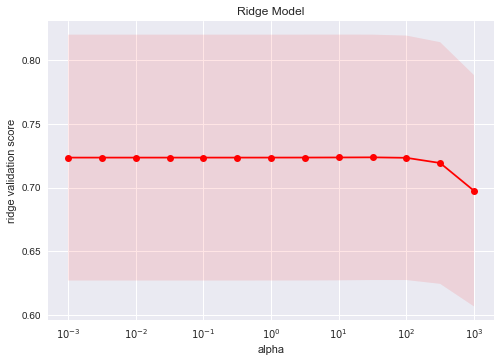

In [25]:
alpha = rgparam_grid['alpha']
rg_score = rg_grid1.cv_results_['mean_test_score'].reshape((1,len(alpha)))
for ind, i in enumerate(rg_score):
    plt.xscale('log')
    plt.plot(alpha, rg_score[ind],"o-",color='r')
    plt.xlabel('alpha')
    plt.ylabel('ridge validation score') 
    plt.title("Ridge Model")
    plt.fill_between(alpha,rg_grid1.cv_results_['mean_test_score']
                     +rg_grid1.cv_results_['std_test_score'],
                     rg_grid1.cv_results_['mean_test_score']-
                     rg_grid1.cv_results_['std_test_score'], 
                     facecolor = 'r', alpha=0.1)
plt.show()

### Model 3: Lasso

In [26]:
print("Lasso cv score: {:.6f}".format(
    np.mean(cross_val_score(Lasso(tol = 0.1),X_train,y_train))))

Lasso cv score: 0.709861


In [27]:
laparam_grid = {'alpha': np.logspace(-3, 0, 13)}
la_grid = GridSearchCV(Lasso(tol=0.1), laparam_grid)
la_grid.fit(X_train, y_train)
print("Lasso best parameter : {}".format(la_grid.best_params_['alpha']))
print("Lasso grid search best score: {:.6f}".format(la_grid.best_score_))

Lasso best parameter : 0.0017782794100389228
Lasso grid search best score: 0.762019


#### With Standard Scaler

In [28]:
LA = Lasso(tol = 0.1).fit(X_train_scaled, y_train)
print("Lasso cv score: {:.6f}".format(
    np.mean(cross_val_score(LA, X_train_scaled, y_train))))

Lasso cv score: 0.628991


In [29]:
la_pipe = make_pipeline(StandardScaler(), Lasso(tol=0.1))
laparam_grid1 = {'lasso__alpha': np.logspace(-3, 0, 13)}
la_grid1 = GridSearchCV(la_pipe, laparam_grid1, cv = 10).fit(X_train, y_train)
print("Lasso best parameter: {}".format(la_grid1.best_params_))
print("Lasso grid search score: {:.6f}".format(la_grid1.score(X_train, y_train)))

Lasso best parameter: {'lasso__alpha': 0.001}
Lasso grid search score: 0.778077


In [30]:
print("Lasso cv test score: {:.6f}".format(LA.score(X_test_scaled, y_test)))

Lasso cv test score: 0.614798


In [31]:
print("Lasso grid search test score: {:.6f}".format(la_grid1.score(X_test, y_test)))

Lasso grid search test score: 0.682712


In [32]:
#la_pipe.get_params().keys()
#la_grid1.cv_results_

#### Visualization

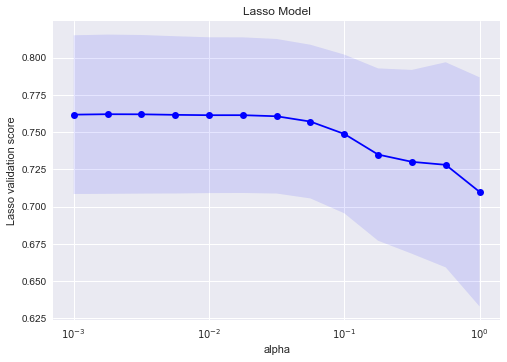

In [33]:
alpha = laparam_grid['alpha']
la_score = la_grid.cv_results_['mean_test_score'].reshape((1,len(alpha)))
for ind, i in enumerate(la_score):
    plt.xscale('log')
    plt.plot(alpha, la_score[ind], 'o-', color='b')
    plt.xlabel('alpha')
    plt.ylabel('Lasso validation score')
    plt.title("Lasso Model")
    plt.fill_between(alpha,la_grid.cv_results_['mean_test_score']+
                     la_grid.cv_results_['std_test_score'],
                     la_grid.cv_results_['mean_test_score']-
                     la_grid.cv_results_['std_test_score'], 
                     facecolor = 'b', alpha=0.1)
plt.show()

### Model 4: Elastic Net

In [34]:
print("ElasticNet cv score: {:.6f}".format(
    np.mean(cross_val_score(ElasticNet(tol = 0.1),X_train,y_train))))

ElasticNet cv score: 0.710193


In [35]:
elparam_grid = {'alpha': np.logspace(-4, -1, 10),
          'l1_ratio': [0.01, .1, .5, .9, .98, 1]}
el_grid = GridSearchCV(ElasticNet(tol=0.2), elparam_grid)
el_grid.fit(X_train, y_train)
print("ElasticNet best parameter: {:}".format(el_grid.best_params_))
print("ElasticNet grid search best score: {:.6f}".format(el_grid.best_score_))

ElasticNet best parameter: {'l1_ratio': 0.01, 'alpha': 0.021544346900318822}
ElasticNet grid search best score: 0.760376


#### With Standard Scaler

In [36]:
EL = ElasticNet(tol = 0.1).fit(X_train_scaled, y_train)
print("Elastic Net cv score: {:.6f}".format(
    np.mean(cross_val_score(EL, X_train_scaled, y_train))))

Elastic Net cv score: 0.647016


In [37]:
el_pipe = make_pipeline(StandardScaler(), ElasticNet(tol=0.2))
elparam_grid1 = {'elasticnet__alpha': np.logspace(-4, -1, 10),
          'elasticnet__l1_ratio': [0.01, .1, .5, .9, .98, 1]}
el_grid1 = GridSearchCV(el_pipe, elparam_grid1).fit(X_train, y_train)
print("Elastic Net best parameter: {}".format(el_grid1.best_params_))
print("Elastic Net grid search score: {:.6f}".format(el_grid1.score(X_train, y_train)))

Elastic Net best parameter: {'elasticnet__l1_ratio': 0.5, 'elasticnet__alpha': 0.10000000000000001}
Elastic Net grid search score: 0.773540


In [38]:
print("Elastic Net cv test score: {:.6f}".format(EL.score(X_test_scaled, y_test)))

Elastic Net cv test score: 0.629263


In [39]:
print("Elastic Net test score: {:.6f}".format(el_grid1.score(X_test, y_test)))

Elastic Net test score: 0.683592


#### Visualization

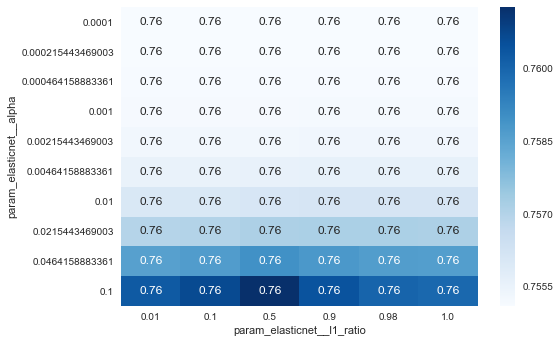

In [40]:
res = pd.pivot_table(pd.DataFrame(el_grid1.cv_results_),
    values='mean_test_score', index='param_elasticnet__alpha', columns='param_elasticnet__l1_ratio')
ax = sns.heatmap(res,annot=True,cmap='Blues')
plt.show()

# Task 2: Feature Engineering

In [41]:
EL1 = ElasticNet(alpha = el_grid1.best_params_['elasticnet__alpha'],
                 l1_ratio = el_grid1.best_params_['elasticnet__l1_ratio'],
                 tol=0.2).fit(X_train_scaled, y_train) #Best Linear model

In [42]:
poly = PolynomialFeatures()
X_train_subpoly = poly.fit_transform(X_train_scaled)
print(X_train_subpoly.shape)

(3701, 300)


In [43]:
EL1.fit(X_train_subpoly, y_train)
EL1.score(X_train_subpoly,y_train)

0.86365367596656073

In [44]:
X_test_subpoly = poly.fit_transform(X_test_scaled)
print(X_test_subpoly.shape)

(1220, 300)


In [45]:
EL1.fit(X_test_subpoly, y_test)
EL1.score(X_test_subpoly,y_test)

0.87905572002205024

## Task 3: Any models

trees, forests, gradient boosting, SVM

tree easy to get overfitting(set some parameters, check ppt)

Need to modify some preprocessing while training the model, do it seperatly. 

Do not train the model on X_test, y_test to avoid information leaking.


## Task 4: Feature Selection

### SelectKBest using Elastic Net (Warning: require modification)

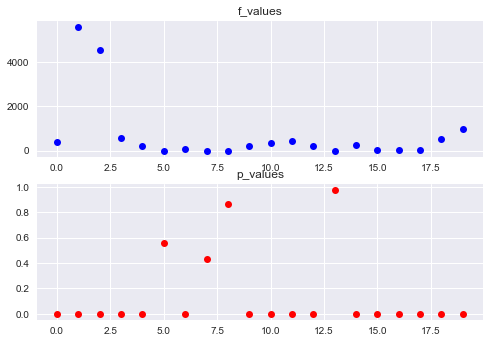

In [105]:
f_values, p_values = f_regression(X_train, y_train)
plt.figure(1)
plt.subplot(211)
plt.plot(f_values, 'bo')
plt.title('f_values')

plt.subplot(212)
plt.plot(p_values,'ro')
plt.title('p_values')
plt.show()

In [106]:
select = SelectKBest(k=17, score_func=f_regression)
select.fit(X_train, y_train)
print(X_train.shape)
X_train_sub = select.transform(X_train)
print(X_train_sub.shape)

(3701, 20)
(3701, 17)


In [107]:
EL1.fit(X_train_sub, y_train)
EL1.score(X_train_sub,y_train)

0.76416033413460782

In [108]:
X_test_sub = select.transform(X_test)
print(X_test_sub.shape)
EL1.fit(X_test_sub, y_test)
EL1.score(X_test_sub,y_test)

(1220, 17)


0.72623831499522939

### Feature Selection based on coefficient using Ridge

In [94]:
RG1 = Ridge(alpha = rg_grid1.best_params_['ridge__alpha']).fit(X_train_scaled, y_train) # Ridge model

In [133]:
X_train.columns

Index(['Index (Model Type Index)', 'Eng Displ', '# Cyl', '# Gears',
       'Lockup Torque Converter', 'Max Ethanol % - Gasoline', '2Dr Pass Vol',
       '2Dr Lugg Vol', '4Dr Pass Vol', 'Intake Valves Per Cyl',
       'Exhaust Valves Per Cyl', 'Carline Class', 'Unique Label?',
       'Cyl Deact?', 'Var Valve Timing?', 'Camless Valvetrain (Y or N)',
       'Stop/Start System (Engine Management System) Code',
       'Stop/Start System (Engine Management System)  Description',
       '$ You Save over 5 years (amount saved in fuel costs over 5 years - on label) ',
       '$ You Spend over 5 years (increased amount spent in fuel costs over 5 years - on label) '],
      dtype='object')

In [95]:
def select_coef(model,df): #select features with high absolute coefficient 
    dic = {}
    for i in range(0,len(list(df))):
        dic[list(df)[i]] = abs(model.coef_)[i]
    feature_lst = sorted(((value,key) for (key,value) in dic.items()),reverse = True)
    sel_feature =[]
    for j in range(0,20):
        sel_feature.append(feature_lst[j][1])
    return sel_feature

In [96]:
def drop_features(lst, df):
    '''
    lst: list of 20 important selected features
    '''
    df_sub1 = df
    for i in df_sub1.columns:
        if i not in lst:
                del df_sub1[i]
    scaler = StandardScaler()
    scaler.fit(df_sub1)
    df_sub1_scaled = scaler.transform(df_sub1)
    return df_sub1_scaled

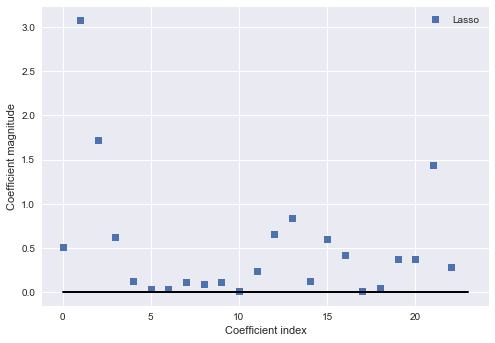

In [97]:
#cofficient plot
plt.plot(abs(RG1.coef_), 's',label="Lasso")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.plot([0,23],[0,0],'k-',lw=2)
plt.show()

In [98]:
feature_lst = select_coef(RG1,X_train) #select important features based on coefficient
X_train_sub1_scaled = drop_features(feature_lst, X_train)
poly = PolynomialFeatures()
X_train_subpoly1 = poly.fit_transform(X_train_sub1_scaled)
print(X_train_sub1_scaled.shape)
print(X_train_subpoly1.shape)

(3701, 20)
(3701, 231)


In [99]:
RG1.fit(X_train_sub1_scaled, y_train)
RG1.score(X_train_sub1_scaled,y_train)

0.77825112655907291

In [100]:
RG1.fit(X_train_subpoly1, y_train)
RG1.score(X_train_subpoly1,y_train)

0.90335963359329496

In [102]:
X_test_sub1_scaled= drop_features(feature_lst, X_test)
poly = PolynomialFeatures()
X_test_subpoly1 = poly.fit_transform(X_test_sub1_scaled)
print(X_test_sub1_scaled.shape)
print(X_test_subpoly1.shape)

(1220, 20)
(1220, 231)


In [103]:
RG1.fit(X_test_sub1_scaled, y_test)
RG1.score(X_test_sub1_scaled,y_test)

0.7356572950396203

In [104]:
RG1.fit(X_test_subpoly1, y_test)
RG1.score(X_test_subpoly1,y_test) #highest test score with Ridge_scaled_best param

0.9171231712701422

### Using feature_selection.RFECV 

### Using feature_selection.RFE